# Assignment 4: Explainability

*Part of the course:
Machine Learning (code: INFOB3ML), fall 2023, Utrecht University*

Total points: 10 (100%)

Deadline: Friday 3 November, 23:59

**Write your names and student numbers here: _ Robin van Gelooven (1745743), Loes Pieterse (8293988)__**

Submit one ipynb file per pair.

**Before you submit, click Kernel > Restart & Run All to make sure you submit a working version of your code!**



## Installation

For this assignment, we are going to use the following Python packages:

matplotlib, pandas, statsmodels, interpret, scikit-learn, openpyxl and graphviz

In [1]:
# Installing packages
!pip install graphviz
!pip install matplotlib pandas numpy statsmodels interpret scikit-learn openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 47.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 35.6 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 31.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 42.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.3/450.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━

## Downloading the data
We are going to use the combined cycle power plant dataset. This dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. We have the following features: hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V). We will train ML models to predict the net hourly electrical energy output (EP) of the plant.

For a detailed description, see: [[Description](https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant)]

We first need to download and prepare data. 


In [13]:
# Download and unzip data

# Windows users: download the data from https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip
# and unzip the file manually in the same folder as the python notebook

# Note: this cell works fine on Linux based systems and Google Colab
# If you run it on a Windows machine, you will get an error (...'wget' is not recognized as an internal or external command...)
!wget -c https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip
!unzip CCPP.zip

zsh:1: command not found: wget
Archive:  CCPP.zip
   creating: CCPP/
  inflating: CCPP/Folds5x2_pp.ods    
  inflating: CCPP/Folds5x2_pp.xlsx   
  inflating: CCPP/Readme.txt         
  inflating: CCPP/Readme.txt~        


## Loading and preprocessing the data
We split the data into training (first 5000 instances) and validation (the subsequent 2000) and test (the last 2568) sets. We will use the training set to train a model, and validation set to optimize the model hyper-parameters. 


In [14]:
# Load and prepare data
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# global variables
DATA_FILENAME = 'CCPP/Folds5x2_pp.xlsx'
FEATURE_NAMES = ['AT', 'V', 'AP', 'RH']
LABEL_NAME = 'PE'
# Load the data from the excel file
def load_data():
    def split_feature_label(data_set):
        features = data_set[FEATURE_NAMES]
        labels = data_set[LABEL_NAME]
        return features, labels

    data = pd.read_excel(DATA_FILENAME)
    train_set, dev_set, test_set = data[:5000], data[5000: 7000], data[7000:]

    train_features, train_labels = split_feature_label(train_set)
    dev_features, dev_labels = split_feature_label(dev_set)
    test_features, test_labels = split_feature_label(test_set)

    return train_features, train_labels, dev_features, \
        dev_labels, test_features, test_labels


# preprocess (by z-normalization) the data for the regression task
# return the normalized feature sets and corresponding target variables 
def prepare_load_regression_data():
    train_features, train_labels, dev_features, \
        dev_labels, test_features, test_labels = load_data()

    scaler = StandardScaler()
    scaler = scaler.fit(train_features)
    train_features = pd.DataFrame(data=scaler.transform(train_features), columns=FEATURE_NAMES)
    dev_features = pd.DataFrame(data=scaler.transform(dev_features), columns=FEATURE_NAMES)
    test_features = pd.DataFrame(data=scaler.transform(test_features), columns=FEATURE_NAMES)

    return train_features, train_labels, dev_features, \
        dev_labels, test_features, test_labels



## Training and Interpreting a Linear Regression Model

**Q1**. (10)% Train a linear regression model (we recommend the statsmodels package) and report $R^2$ (goodness of fit) statistic. 

For model interpretability, provide for each feature (+ the bias variable) the following in tabular format: 
* Weight estimates
* SE (standard error of estimates) 
* T statistics 


Further Questions regarding the linear model (answers to be included in the notebook): 

**Q2**. (10%) Which three features are the most important?

**Q3**. (10%) How does the gas turbine energy yield (EP) change with unit (one degree C) increase of the ambient temperature given that all other feature values remain the same? (Note: Here you should consider whether you use the original or z-normalized features to train your linear model.)

**Q4**. (10%) Show bar graph illustrations of the feature effects for the first two development set instances.

In [63]:
# We recommend the statsmodels package
import statsmodels.api as sm
# Hint, by default this sm does not include the bias/offset term w_0
# thus, you should add it yourself using sm.add_constant()

# Linear regression
# Get the preprocessed data for linear regression modeling
(train_features, train_labels, dev_features, \
        dev_labels, test_features, test_labels) = prepare_load_regression_data()

# Add a constant (bias) term to the feature matrix
train_features = sm.add_constant(train_features)
dev_features = sm.add_constant(dev_features)
test_features = sm.add_constant(test_features)

model = sm.OLS(train_labels, train_features).fit()

r_squared = model.rsquared
print(f"R-squared: {r_squared:.4f}")

summary = model.summary()
print(summary)


R-squared: 0.9294
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 1.644e+04
Date:                Sun, 29 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:57:45   Log-Likelihood:                -14635.
No. Observations:                5000   AIC:                         2.928e+04
Df Residuals:                    4995   BIC:                         2.931e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.4443      0.064  

In [65]:
# Voor vraag 2: de 3 belangrijkste features krijgen:
belangrijkheid = model.params.abs().sort_values(ascending=False) # oplopende rij gezet welke features het belangrijkste zijn op basis van absolute waardes van laag naar hoog
belangrijkste_features = belangrijkheid.head(3) #hoogste 3 absolute waardes
print("De 3 belangrijkste features:")
print(belangrijkste_features)

De 3 belangrijkste features:
const    454.444328
AT        14.807970
V          2.853379
dtype: float64


In [70]:
# Voor vraag 3
temperatuur_coefficient = model.params['AT'] # Coëfficiënt van de AT feature
ep_verandering = temperatuur_coefficient * 1 # De temperatuur opschalen met 1 graad
print(f"Change in EP with a one-degree increase in AT: {ep_verandering:.4f}")


Change in EP with a one-degree increase in AT: -14.8080


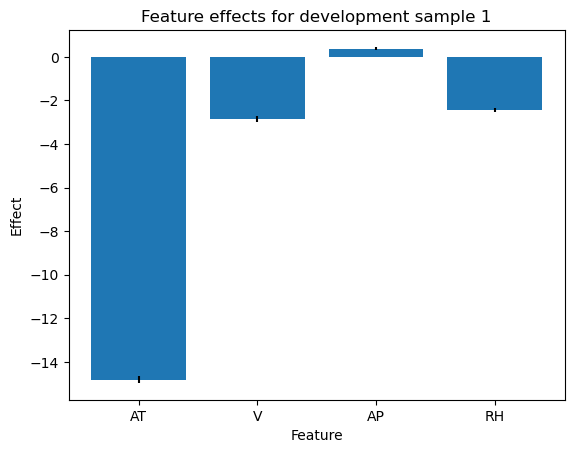

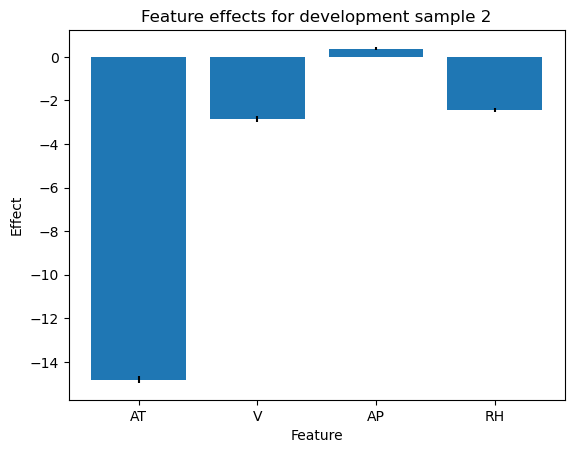

In [71]:
#voor vraag 4:
import matplotlib.pyplot as plt

eerste_2 = dev_features.iloc[:2] #eerste 2 development samples van de dev_features dataset
voorspellingen = model.predict(eerste_2) #voorspelde waarden van de eerste 2 met de training data 

for i, sample in enumerate(eerste_2.index): #voor beide instances en hun index plotten
    plt.bar(FEATURE_NAMES, model.params.values[1:], yerr=model.bse.values[1:]) #vanaf het tweede element omdat de eerste de intercept is, standaardfouten meegenomen (bse)
    plt.title(f"Feature effects for development sample {sample + 1}")
    plt.xlabel("Feature")
    plt.ylabel("Effect")
    plt.show()

**Q5.** (10%) Reflection: why would training a regression tree not work well for this dataset in terms of model interpretability? (answer in the notebook)

This could be due to multible factors: regression trees do not work well with very complex, non linear, relationships. This model might be too complex. Another reason could be because a regression tree splits data into binary decisions at certain tresholds, which makes it hard to see how small changes is features might affect the target. A regression tree is also very sensitive to overfitting.

## Training and Interpreting an Explainable Boosting Model (Generalized Additive Model)
**Q6**. (10%) Train a Explainable Boosting Machine (with [interpret.ml](https://github.com/interpretml/interpret/))

(Note on grading: Training EBM 4%, global and local explanation visualizations - see below -  3% each)

For a tutorial see: [[Tutorial](https://nbviewer.org/github/interpretml/interpret/blob/master/examples/python/notebooks/Interpretable%20Regression%20Methods.ipynb)]


* (3%) Visualize/provide global (model-wise) feature importances for EBM as a table or figure. What are the most important two features in EBM? Are they the same as in the linear model? 
* (3%) Visualize local (instance-wise) feature importances for a development set instance of your choice.


In [ ]:
from interpret.glassbox import ExplainableBoostingRegressor

# EBM

## Training and Explaining Neural Networks
**Q7**. (10%) Train a Neural Network (using the training and validation sets): One-layer MLP (with ReLU activation function and 50 to 100 hidden neurons) 

We recommend to use the Adam optimizer. Fine-tune the learning rate and any other hyper-parameters you find necessary. 

For a tutorial see: [[Tutorial](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)]

Your code should report the results following the instructions below:

Note on grading: training NN: 4%, answering below sub-questions 3% each.

* (3%) Apply the trained neural network model on the test set and report Root Mean Square Error (RMSE) performance measure.

* (3%) Analyzing factors influencing the neural network predictions. 
See the [Documentation](https://scikit-learn.org/stable/modules/partial_dependence.html) to use Partial Dependence Plot (PDP)  implementation in python. Use the trained one-layer MLP model to  Generate and report a bivariate PDP using 'AT' (Ambient Temperature) and 'V' (Exhaust Vacuum) features (Note: not two univariate PDPs but one bivariate PDP).


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay

# One-layer MLP : you can use  learning_rate_init=0.001 to get a reasonable model, optimize other parameters by experimentation
# We advice that you name variable for the mlp regressor model 'mlp_reg' so that it will be consistent 
# with the scripts to call your implementation of PFI later in Q8:
mlp_reg= # ... your scripts here and below

### Generating Model-Agnostic Global Explanations for NN predictions

**Permutation Feature Importance (PFI)**

**Q8**. (20%) Implement the permutation feature importance algorithm using RMSE as the error function (%12). No existing libraries (save measuring RMSE) are allowed to use. We will implement it ourselves.
- (%4) Visualize feature importances obtained by PFI for the NN (one-layer MLP) model you trained using a bar graph.
- (%4) Reflection: What are the most important two features obtained by PFI for MLP model? How do these two features compare to the top two features from the Linear Model and the EBM?

In [ ]:
# Use the below function signature and the parameters to implement PFI
def PFI(X, labels, model, rmse):
# Your scripts implementing PFI here




# Do not modify this part (unless you change the variable name mlp_reg above)
base_rmse = mean_squared_error(dev_labels, mlp_reg.predict(dev_features) , squared=False)
results_df = PFI(dev_features, dev_labels, mlp_reg, base_rmse)

In [ ]:
# Your scripts to visualize results_df using a bar graph here


### Generating Model-Agnostic Explanations for NN predictions
You can check the tutorials for LIME explanations for neural networks 
[[LIME Tutorial](https://nbviewer.org/github/interpretml/interpret/blob/develop/examples/python/Explaining_Blackbox_Regressors.ipynb)]


**Q9**. (10%) Provide LIME-based explanations for trained NN model's predictions on two randomly selected test set instances.  

In [ ]:
# Global explanations
import graphviz
from interpret import show

# Local explanations (LIME)
from interpret.blackbox import LimeTabular
